<img src="imgs/qiskit.png" alt="Qiskit" style="width: 50px;" align="right"/>

# Shor's Algorithm - Final Project
## Qiskit Global Summer School

<hr>

[Spencer Churchill](https://spencerchurchill.github.io)

In [1]:
# imports for RSA
from numpy import pi, mod, gcd, sqrt, log, ceil
from numpy.random import seed, randint

# imports for Shor
from qiskit import QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT

# Introduction

“I have lucrative news to share before it goes public... don’t worry, I encrypted the listing. See you soon.” 

You look up to see a man hastily exit the NY subway, leaving behind a scrap of paper on the ground. Curious, you read the contents of the slip:

<img src="imgs/scrap.png" alt="Paper Scrap" style="width: 25%;" align="center"/>

“Buy `CBD` stock!”

On the bottom, you see what you can only assume is the coprime of an RSA key, `, 15)`

In [2]:
enc_str = "CBD"
N = 15

In [3]:
print(f"You know 3 things:\n\t1. a company is going to report high earnings,",
      f"\n\t2. that company's encrypted stock listing is '{enc_str}', and",
      f"\n\t3. the key's coprime, N, is {N}.")

You know 3 things:
	1. a company is going to report high earnings, 
	2. that company's encrypted stock listing is 'CBD', and 
	3. the key's coprime, N, is 15.


# RSA Algorithm

In [4]:
def rsa(P, Q):
    N = P * Q # modulus <-- the hard number to crack!
    
    if N % 2 == 0:
        val = P if P % 2 == 0 else Q
        raise ValueError(f"{N} can not be divisible by 2.",
                         f"{P} and {Q} are incompatible with Shor's Algorithm.")
    
    L = (Q - 1) * (P - 1) # number of non-common factors (1, N)
    
    for E in range(2, L): # between [2, L)
        if gcd(L, E) * gcd(N, E) == 1: # coprime with both L and N
            break # E is public value

    D = 1
    while True:
        if D * E % L == 1 and D != E and D != N:
            break # D is private value
        D += 1

    return ((E, N), (D, N))

def dec_guess(string, key):
    D, N = key
    return "".join([chr((((ord(char) - ord('A'))**D) % N) +
                        ord('A')) for char in string])

The prospect of cracking an insider trade is too compelling to ignore, so you try to guess the solution.

In [5]:
P = Q = 0

print("Guesses:")
for i in range(3):
    print(f"\t{i+1}. {dec_guess(enc_str, (i, 15))}")

Guesses:
	1. BBB
	2. CBD
	3. EBJ


However, RSA is too secure to simply be guessed. The asymmetric modular function is constructed in such a way as to only allow the private key to unlock the encryption. The scrap only has the coprime factor of the key though.

<img src="imgs/rsa.png" alt="RSA" style="width: 50%;" align="center"/>

The only way to read the listing would be to

1. factor the coprime factor,
2. use those factors to generate the private key,
3. then decrypt the listing with the private key.

Luckily, you attended Abe's lecture on Shor's algorithm and know exactly how to begin!

# Shor's Algorithm

You review and write out each step from the notes

## Step 1

Pick an integer a such that 1 < a < N and gcd(a, N) = 1.

In [6]:
seed(1) # for consistent values

a = 0
while a == 0:
    b = randint(2, N) # 1 < a < N
    if gcd(b, N) == 1:
        a = b

print(f"{1} < {a} < {N}, {1 < a < N}")

1 < 7 < 15, True


## Step 2

Find the period of $f(x) = a^{x} mod N$.

This is the when you connect to your [quantum computer](https://quantum-computing.ibm.com/) and begin making your period-finding circuit.

<img src="imgs/qcircuit.png" alt="Quantum Circuit" style="width: 50%;" align="center"/>

In [7]:
def initialize_qubits(qc, n):
    qc.h(range(n))
    qc.x(-1)

In [8]:
def a_x_mod15(a, x):
    if a not in [2,7,8,11,13]:
        raise ValueError("'a' must be 2,7,8,11 or 13")
    U = QuantumCircuit(4)        
    for iteration in range(x):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a == 11:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = f"{a}^{x} % 15"
    c_U = U.control()
    return c_U

In [9]:
def modular_exponentiation(qc, n, a):
    for q in range(n):
        qc.append(a_x_mod15(a, 2**q), 
                     [q] + [i+n for i in range(4)])

In [10]:
def apply_iqft(qc, measurement_qubits):
    qc.append(QFT(len(measurement_qubits),
                  do_swaps=False).inverse(),
                  measurement_qubits)

In [11]:
def period_finder(n, a):
    
    # set up quantum circuit
    qc = QuantumCircuit(n+4, n)
    
    # initialize the qubits
    initialize_qubits(qc, n)
    qc.barrier()

    # apply modular exponentiation
    modular_exponentiation(qc, n, a)
    qc.barrier()

    # apply inverse QFT
    apply_iqft(qc, range(n))
    qc.barrier()

    # measure the first n qubits
    qc.measure(range(n), range(n))
    
    return qc

In [12]:
n = 3

qc = period_finder(n, a)
qc.draw(output='text')

┌───┐ ░                                         ░ ┌───────┐ ░ ┌─┐      
q_0: ┤ H ├─░───────■─────────────────────────────────░─┤0      ├─░─┤M├──────
     ├───┤ ░       │                                 ░ │       │ ░ └╥┘┌─┐   
q_1: ┤ H ├─░───────┼────────────■────────────────────░─┤1 iqft ├─░──╫─┤M├───
     ├───┤ ░       │            │                    ░ │       │ ░  ║ └╥┘┌─┐
q_2: ┤ H ├─░───────┼────────────┼────────────■───────░─┤2      ├─░──╫──╫─┤M├
     └───┘ ░ ┌────┴┼─────┐┌────┴┼─────┐┌────┴┼─────┐ ░ └───────┘ ░  ║  ║ └╥┘
q_3: ──────░─┤0    │     ├┤0    │     ├┤0    │     ├─░───────────░──╫──╫──╫─
           ░ │           ││           ││           │ ░           ░  ║  ║  ║ 
q_4: ──────░─┤1          ├┤1          ├┤1          ├─░───────────░──╫──╫──╫─
           ░ │  7^1 % 15 ││  7^2 % 15 ││  7^4 % 15 │ ░           ░  ║  ║  ║ 
q_5: ──────░─┤2          ├┤2          ├┤2          ├─░───────────░──╫──╫──╫─
     ┌───┐ ░ │           ││           ││           │ ░           ░  ║  ║  ║ 
q_6: ┤ X ├─░─┤3          ├┤3          ├┤3          ├─░───────────░──╫──╫──╫─
     └───┘ ░ └───────────┘└───────────┘└───────────┘ ░           ░  ║  ║  ║ 
c_0: ═══════════════════════════════════════════════════════════════╩══╬══╬═
                                                                       ║  ║ 
c_1: ══════════════════════════════════════════════════════════════════╩══╬═
                                                                          ║ 
c_2: ═════════════════════════════════════════════════════════════════════╩═

This circuit will hopefully return the period.

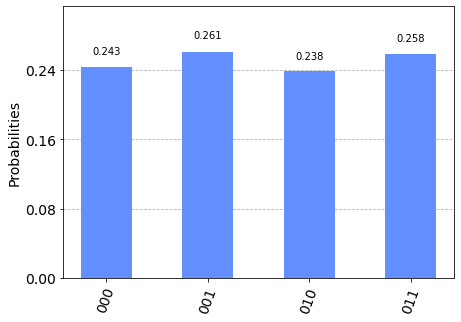

In [13]:
simulator = Aer.get_backend('qasm_simulator')
counts = execute(qc, backend=simulator).result().get_counts(qc)

plot_histogram(counts)

In [14]:
counts_dec = sorted([int(measured_value[::-1], 2) for measured_value in counts])

print("Measured:", end='\t')
for measured_value in counts_dec:
    print(measured_value, end='\t')

Measured:	0	2	4	6	

In [15]:
factors = set()

for measured_value in counts_dec:
    if measured_value % 2 == 0:
        x = int((a ** (measured_value/2)) % N)
        if (x + 1) % N != 0:
            guesses = [gcd(x + 1, N), gcd(x - 1, N)]
            for guess in guesses:
                if guess != 1 and guess != N and N % guess == 0:
                    factors.add(guess)

if len(factors) == 2:
    P = factors.pop()
    Q = factors.pop()
    print(f"P = {P}\nQ = {Q}")
else:
    print("Shor's Algorithm Failed. Choose a different 'a'.")

P = 3
Q = 5


- Use P and Q to retrieve the first half of the key

In [16]:
_, priv_key = rsa(P, Q)
print("Using RSA and Shor's Algorithm,",
      f"you determine the private key to be {priv_key}")

Using RSA and Shor's Algorithm, you determine the private key to be (23, 15)


- now you use that key to decrypt the stock listing

In [17]:
dec_str = dec_guess(enc_str, priv_key)
print(f"You find that the decrypted listing is {dec_str}!")

You find that the decrypted listing is IBM!


- being the smart quantum programmer that you are, you decide (not) to buy IBM stock. you enjoy the rest of your day knowing you did the right thing.

## Sources

- [RSA Tutorial](https://hackernoon.com/how-does-rsa-work-f44918df914b)
- [Qiskit Textbook - Shor's Algorithm](https://qiskit.org/textbook/ch-algorithms/shor.html)
- [Qiskit Lecture](https://www.crowdcast.io/e/qgss-day4)
- [Period Finding Steps](https://en.wikipedia.org/wiki/Shor%27s_algorithm#Procedure)
